# 양방향 LSTM을 이용한 개체명 인식(Named Entity Recognition using Bi-LSTM)

### BIO 표현

가장 보편적인 방법 중 하나인 IOB (또는 BIO) 방법을 소개합니다. B는 Begin의 약자로 개체명이 시작되는 부분, I는 Inside의 약자로 개체명의 내부 부분을 의미하며, O는 Outside의 약자로 개체명이 아닌 부분을 의미합니다.

### 개체명 인식 데이터 이해하기


다운로드 링크 : https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/master/neuroner/data/conll2003/en/train.txt

In [1]:
import re
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
f = open('C:/Users/it/Downloads/dataset/train.txt', 'r')

In [3]:
tagged_sentences = []
sentence = []

for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
        if len(sentence) > 0:
            tagged_sentences.append(sentence)
            sentence = []
        continue
    splits = line.split(' ') # 공백을 기준으로 속성을 구분한다.
    splits[-1] = re.sub(r'\n', '', splits[-1]) # 줄바꿈 표시 \n을 제거한다.
    word = splits[0].lower() # 단어들은 소문자로 바꿔서 저장한다.
    sentence.append([word, splits[-1]]) # 단어와 개체명 태깅만 기록한다.

In [4]:
print('전체 샘플 개수 : ', len(tagged_sentences))

전체 샘플 개수 :  14041


In [5]:
print(tagged_sentences[0])

[['eu', 'B-ORG'], ['rejects', 'O'], ['german', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['british', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


In [6]:
sentences, ner_tags = [], []
for tagged_sentence in tagged_sentences:
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentences.append(list(sentence))
    ner_tags.append(list(tag_info))

In [7]:
print(sentences[110])
print(ner_tags[110])

['"', 'the', 'voices', 'coming', 'out', 'of', 'damascus', 'are', 'bad', ',', 'not', 'good', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O']


샘플 최대 길이 :  113
샘플 평균 길이 :  14.501887329962253


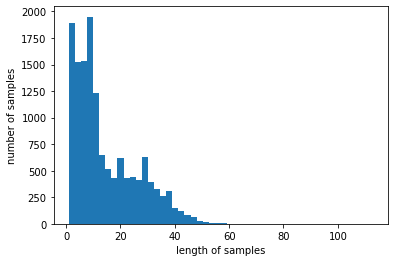

In [8]:
print('샘플 최대 길이 : ', max(len(l) for l in sentences))
print('샘플 평균 길이 : ', sum(map(len, sentences)) / len(sentences))

plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [9]:
max_words = 4000
src_tokenizer = Tokenizer(num_words=max_words, oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)

In [10]:
vocab_size = max_words
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태그 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 4000
개체명 태그 정보 집합의 크기 : 10


In [11]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

In [12]:
print(X_train[0])
print(y_train[0])

[989, 1, 205, 629, 7, 3939, 216, 1, 3]
[4, 1, 7, 1, 1, 1, 7, 1, 1]


In [13]:
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word

In [14]:
decoded = []
for index in X_train[0]:
    decoded.append(index_to_word[index])
print('기존 문장 : {}'.format(sentences[0]))
print('빈도수가 낮은 단어가 OOV 처리된 문장 : {}'.format(decoded))

기존 문장 : ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
빈도수가 낮은 단어가 OOV 처리된 문장 : ['eu', 'OOV', 'german', 'call', 'to', 'boycott', 'british', 'OOV', '.']


In [15]:
max_len = 70
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=777)

In [17]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [18]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (11232, 70)
훈련 샘플 레이블의 크기 : (11232, 70, 10)
테스트 샘플 문장의 크기 : (2809, 70)
테스트 샘플 레이블의 크기 : (2809, 70, 10)


### 양방향 LSTM(Bi-directional LSTM)으로 개체명 인식기 만들기

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import Adam

In [20]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))

Many-to-Many 문제이므로 LSTM()에 return_sequences=True를 설정해준 것을 볼 수 있습니다. 또한, 이번 실습과 같이 각 데이터의 길이가 달라서 패딩을 하느라 숫자 0이 많아질 경우에는 Embedding()에 mask_zero=True를 설정하여 데이터에서 숫자 0은 패딩을 의미하므로 연산에서 제외시킨다는 옵션을 줄 수 있습니다.

In [21]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [22]:
model.fit(X_train, y_train, batch_size=128, epochs=8, validation_data=(X_test, y_test))

Train on 11232 samples, validate on 2809 samples
Epoch 1/8
11232/11232 [==============================] - 203s 18ms/sample - loss: 0.1863 - accuracy: 0.8232 - val_loss: 0.1232 - val_accuracy: 0.8325
Epoch 2/8
11232/11232 [==============================] - 215s 19ms/sample - loss: 0.0974 - accuracy: 0.8562 - val_loss: 0.0752 - val_accuracy: 0.8843
Epoch 3/8
11232/11232 [==============================] - 212s 19ms/sample - loss: 0.0655 - accuracy: 0.9040 - val_loss: 0.0532 - val_accuracy: 0.9228
Epoch 4/8
11232/11232 [==============================] - 212s 19ms/sample - loss: 0.0476 - accuracy: 0.9324 - val_loss: 0.0418 - val_accuracy: 0.9423
Epoch 5/8
11232/11232 [==============================] - 212s 19ms/sample - loss: 0.0364 - accuracy: 0.9492 - val_loss: 0.0353 - val_accuracy: 0.9518
Epoch 6/8
11232/11232 [==============================] - 212s 19ms/sample - loss: 0.0296 - accuracy: 0.9584 - val_loss: 0.0328 - val_accuracy: 0.9553
Epoch 7/8
11232/11232 [============================

In [23]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

2809/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================


 테스트 정확도: 0.9560
